# Guide to bias correcting ensemble boosted climate model data
Samuel Lüthi, 18.09.2024

In this notebook I briefly highlight how we can bias-correct ensemble boosted climate model data to observed data.

The idea is that we use the corresponding large ensemble to calibrate a quantile mapping function for
bias correction and then apply the same qm correction term to the ensemble boosts.

Thus we need:
- an observational time series as ground truth
- the nearest neighbour ensemble boosted heatwave to this obs series
- the nearest neighbour large ensmble data covering the same time horizon as the obs series

The bias_correction functions are available on
https://github.com/samluethi/ProbaHeat/blob/main/Full_scripts/SMILE_data_prep/bias_correction.py

This code is a slightly simplified version, translated to python, of the method published by
Rajczak et al. (2016). doi:10.1002/joc.4417 

In [75]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as stats
import seaborn as sns
from pathlib import Path

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/WCR/Projects/Heat/Storyline/Scripts/Python_scripts/storyline_classes/')
from bias_correction import *


In [76]:
# load data
DP = Path('/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/WCR/Projects/Heat/Storyline/Data/Develop_heat_mort/')
# obs temperature
obs_fluntern = pd.read_hdf(DP.joinpath('Develop_class/fluntern.h5'), key='df')
obs_fluntern = obs_fluntern.loc['2000-01-01':]
# CESM2 data
CESM_LE_SHORT = pd.read_hdf(DP.joinpath('CESM2_LE/CESM2_ZRH_35members_2005_2023.h5'), key='df')
CESM_LE_FULL = pd.read_hdf(DP.joinpath('CESM2_LE/CESM2_ZRH_35members_2005_2035.h5'), key='df')
boost_july15 = pd.read_hdf(DP.joinpath('Boosted_runs/CESM2_Boost_ZRH_2015-07-07.h5'), key='df')
boost_july31 = pd.read_hdf(DP.joinpath('Boosted_runs/CESM2_Boost_ZRH_2031-07-10.h5'), key='df')


## First we can briefly look at how to bias correct a large ensemble
We take one correction function for the whole ensemble, this allows keeping some more variability.
Also, we only correct up to the 99th percentile, to not overfit at the tail.

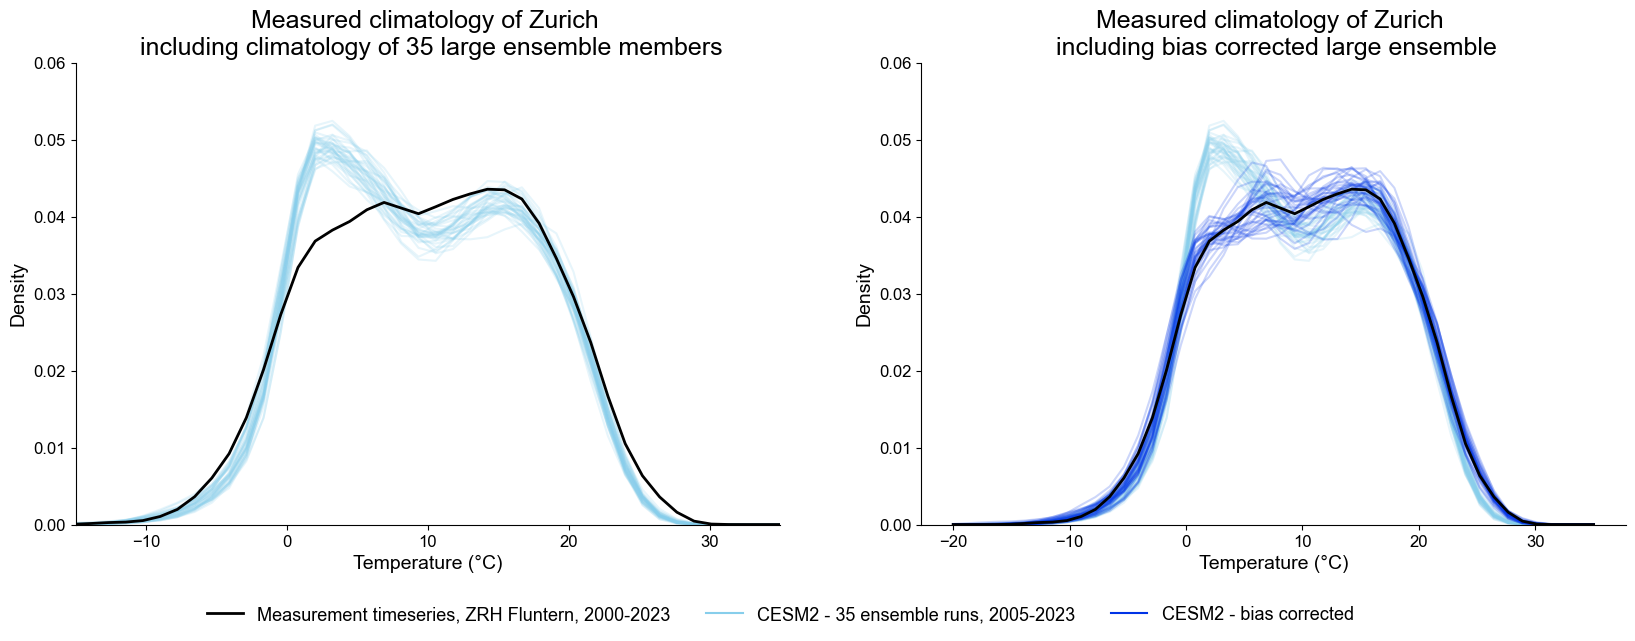

In [77]:
# do bias correction
CESM_BC = bias_correct_ensemble(CESM_LE_SHORT, obs_fluntern.T2M, CESM_LE_SHORT, # full model data (align with obs), observed data, data to correct
                          minq=0.1, maxq=0.99, incq=0.001)
cols = sns.color_palette("winter", 4)

# make figure with two subplots
plt.rcParams.update({'font.family':'arial'})
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

bins=np.linspace(-20, 35, 46)
# plot with no bias correction
for i in range(CESM_LE_FULL.shape[1]):
    density = stats.gaussian_kde(CESM_LE_FULL.iloc[:,i])
    axs[0].plot(bins, density(bins), color="skyblue", alpha=0.2)
density = stats.gaussian_kde(obs_fluntern.T2M)
axs[0].plot(bins, density(bins), color="black", linewidth=2)
axs[0].set_xlabel("Temperature (°C)", fontsize=14)
axs[0].set_ylabel("Density", fontsize=14)
axs[0].set_xlim([-15, 35])
axs[0].set_ylim([0., 0.06])
axs[0].set_title('Measured climatology of Zurich \n including climatology of 35 large ensemble members', fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=12)
sns.despine()

# plot with bias correction
for i in range(CESM_LE_FULL.shape[1]):
    density = stats.gaussian_kde(CESM_LE_FULL.iloc[:,i])
    axs[1].plot(bins, density(bins), color="skyblue", alpha=0.2)
for i in range(CESM_LE_FULL.shape[1]):
    density = stats.gaussian_kde(CESM_BC.iloc[:,i])
    axs[1].plot(bins, density(bins), color=cols[0], alpha=0.2)

density = stats.gaussian_kde(obs_fluntern.T2M)
axs[1].plot(bins, density(bins), color="black", linewidth=2)
axs[1].set_xlabel("Temperature (°C)", fontsize=14)
axs[1].set_ylabel("Density", fontsize=14)
axs[0].set_xlim([-15, 35])
axs[1].set_ylim([0., 0.06])
axs[1].set_title('Measured climatology of Zurich \n including bias corrected large ensemble', fontsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=12)
sns.despine()

p1 = plt.plot(np.NaN, np.NaN, color="black", linewidth=2)
p2 = plt.plot(np.NaN, np.NaN, color="skyblue")
p3 = plt.plot(np.NaN, np.NaN, color=cols[0])

plt.legend([p1[0], p2[0], p3[0]],
           ['Measurement timeseries, ZRH Fluntern, 2000-2023',
            'CESM2 - 35 ensemble runs, 2005-2023',
            'CESM2 - bias corrected'],
           bbox_to_anchor=(-0.2, -0.25), loc='lower center',
            fontsize=13, frameon=False, ncol=3)
plt.show()

## Apply same logic to ensemble boosted data

The correction function is estimated based on the large ensemble and then applied to the boosted data.
Here, I plot all 1100 realisations of 1 boosted heatwave. As these realisations are only 50 day long
and only sample at the hot tail of the obs distribution, the density is obviously very high arund the tail.

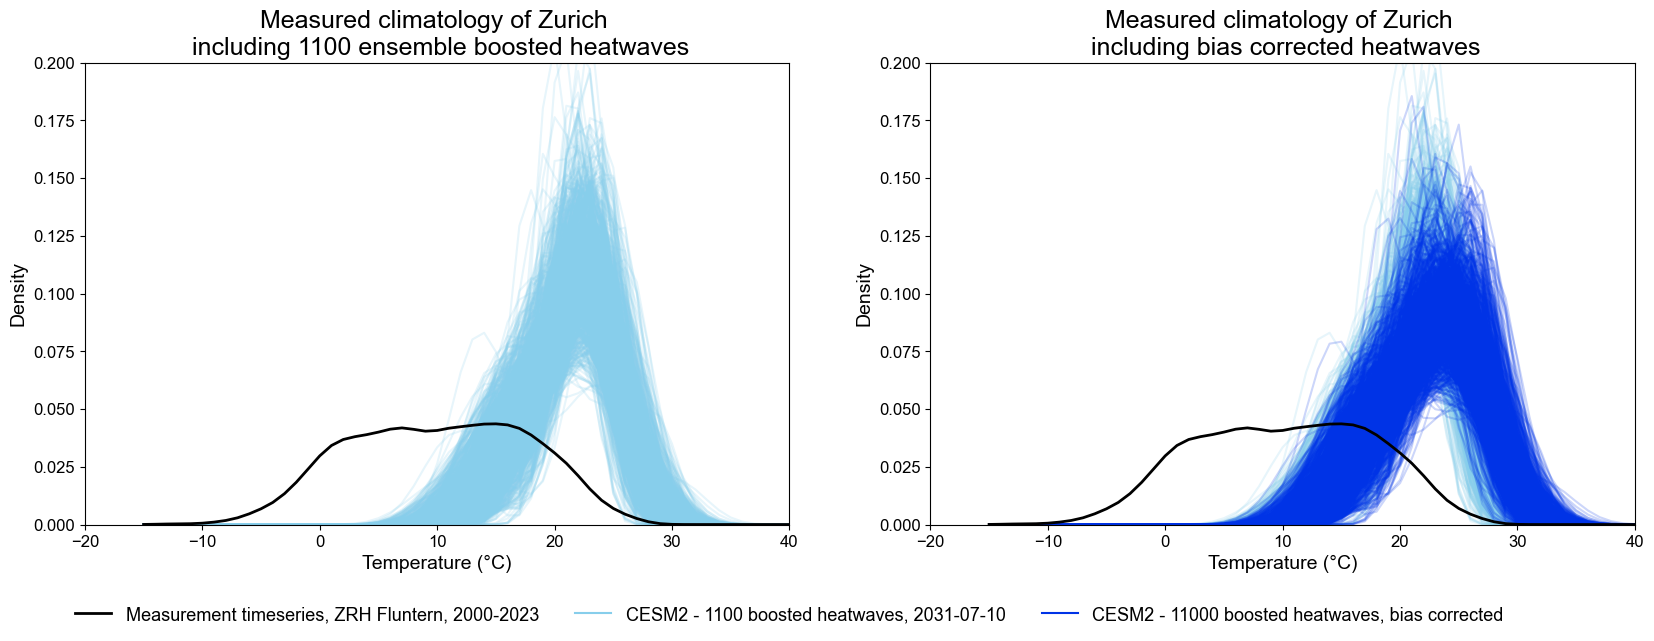

In [79]:
# do bias correction
BOOST_BC = bias_correct_ensemble(CESM_LE_SHORT, obs_fluntern.T2M, boost_july31, # full model data (align with obs), observed data, data to correct
                          minq=0.1, maxq=0.999, incq=0.001)
cols = sns.color_palette("winter", 4)

# make figure with two subplots
plt.rcParams.update({'font.family':'arial'})
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

bins=np.linspace(-15, 45, 61)
# plot with no bias correction
for i in range(boost_july31.shape[1]):
    density = stats.gaussian_kde(boost_july31.iloc[:,i].dropna())
    axs[0].plot(bins, density(bins), color="skyblue", alpha=0.2)
density = stats.gaussian_kde(obs_fluntern.T2M)
axs[0].plot(bins, density(bins), color="black", linewidth=2)
axs[0].set_xlabel("Temperature (°C)", fontsize=14)
axs[0].set_ylabel("Density", fontsize=14)
axs[0].set_xlim([-20, 40])
axs[0].set_ylim([0., 0.2])
axs[0].set_title('Measured climatology of Zurich \n including 1100 ensemble boosted heatwaves', fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# plot with bias correction
for i in range(boost_july31.shape[1]):
    density = stats.gaussian_kde(boost_july31.iloc[:,i].dropna())
    axs[1].plot(bins, density(bins), color="skyblue", alpha=0.2)
for i in range(BOOST_BC.shape[1]):
    density = stats.gaussian_kde(BOOST_BC.iloc[:,i].dropna())
    axs[1].plot(bins, density(bins), color=cols[0], alpha=0.2)

density = stats.gaussian_kde(obs_fluntern.T2M)
axs[1].plot(bins, density(bins), color="black", linewidth=2)
axs[1].set_xlabel("Temperature (°C)", fontsize=14)
axs[1].set_ylabel("Density", fontsize=14)
axs[1].set_xlim([-20, 40])
axs[1].set_ylim([0., 0.2])
axs[1].set_title('Measured climatology of Zurich \n including bias corrected heatwaves', fontsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.legend([p1[0], p2[0], p3[0]],
           ['Measurement timeseries, ZRH Fluntern, 2000-2023',
            'CESM2 - 1100 boosted heatwaves, 2031-07-10',
            'CESM2 - 11000 boosted heatwaves, bias corrected'],
           bbox_to_anchor=(-0.2, -0.25), loc='lower center',
            fontsize=13, frameon=False, ncol=3)


## Time series of boosted heatwaves
Finally, we can look at two heatwaves and the effect of the bias-correction

In [80]:

obs_series = obs_fluntern.T2M
# remove leap days
obs_series = obs_series[~((obs_series.index.month == 2) & (obs_series.index.day == 29))]
obs_full = pd.DataFrame(obs_series.values.reshape(-1, 365)).T
obs_full.columns = np.arange(2000, 2024)

# calculate climatology
df_climatology = pd.DataFrame()
df_climatology['Mean'] = obs_full.mean(axis=1)
df_climatology['Std'] = obs_full.std(axis=1)
# smooth the climatology
df_climatology['Mean'] = df_climatology['Mean'].rolling(window=14, center=True).mean()
df_climatology['Std'] = df_climatology['Std'].rolling(window=14, center=True).mean()
df_climatology.index = np.arange(1, 366)

smooth = 3
boost_7d = boost_july31['2031-07-12_ens021'].rolling(window=smooth, center=True).mean()
boost_7d_bc = BOOST_BC['2031-07-12_ens021'].rolling(window=smooth, center=True).mean()
boost_35d = boost_july31['2031-07-12_ens081'].rolling(window=smooth, center=True).mean()
boost_35d_bc = BOOST_BC['2031-07-12_ens081'].rolling(window=smooth, center=True).mean()

# bring boosts to 365-day
doy = boost_7d.index.dayofyear
boost_7d.index = doy
boost_7d_bc.index = doy
boost_35d.index = doy
boost_35d_bc.index = doy

boost_7d_full = pd.Series(np.NaN, index=np.arange(1, 366))
boost_7d_full.loc[boost_7d.index] = boost_7d
boost_7d_bc_full = pd.Series(np.NaN, index=np.arange(1, 366))
boost_7d_bc_full.loc[boost_7d_bc.index] = boost_7d_bc
boost_35d_full = pd.Series(np.NaN, index=np.arange(1, 366))
boost_35d_full.loc[boost_35d.index] = boost_35d
boost_35d_bc_full = pd.Series(np.NaN, index=np.arange(1, 366))
boost_35d_bc_full.loc[boost_35d_bc.index] = boost_35d_bc

# obs
obs_max = obs_full[2003].rolling(window=smooth, center=True).mean()
obs_max.index = np.arange(1, 366)


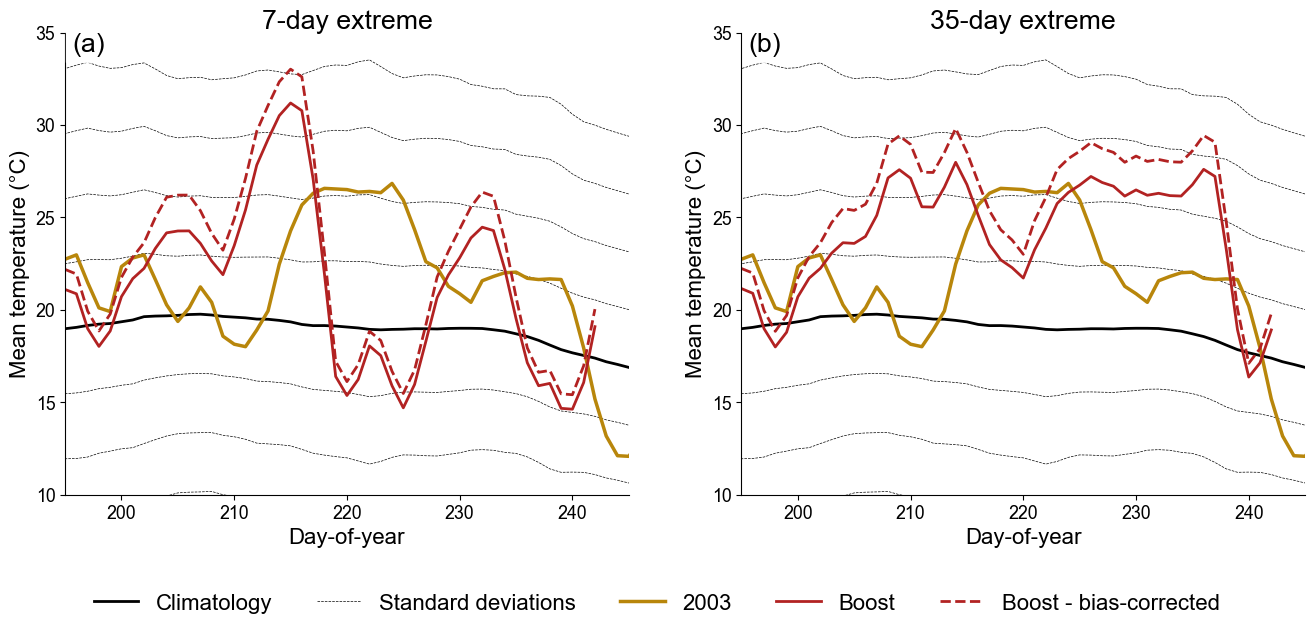

In [81]:

# set font to Arial
plt.rcParams['font.sans-serif'] = "Arial"
fontsize = 16
n_std = 4
d_start = 195
d_end = 245
fig, ax = plt.subplots(figsize=(16,6))
grid = plt.GridSpec(1, 2) # create a grid for the subplots
ax = plt.subplot(grid[0, 0])
# set title
ax.text(0.5, 1.05, '7-day extreme', fontsize=fontsize*1.2,
        ha='center', va='top', transform=ax.transAxes)
df_climatology['Mean'].plot(ax=ax, color='black', linewidth=2, label='Climatology')
for i in range(1, n_std+1):
    ax.plot(df_climatology.index, df_climatology['Mean']-i*df_climatology['Std'],
            color='black', linewidth=0.5, linestyle='--')
    ax.plot(df_climatology.index, df_climatology['Mean']+i*df_climatology['Std'],
            color='black', linewidth=0.5, linestyle='--')


obs_max.plot(ax=ax, color='darkgoldenrod', alpha=1, linewidth=2.5, label='2003')
ax.plot(boost_7d_full.index, boost_7d_full, color='firebrick', linewidth=2, label='Max Boosts 7d')
ax.plot(boost_7d_bc_full.index, boost_7d_bc_full, color='firebrick', linewidth=2, label='Max Boosts 7d - BC', linestyle='--')

# make ticks bigger
ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax.set_xlabel('Day-of-year', fontsize=fontsize)
ax.set_ylabel('Mean temperature (°C)', fontsize=fontsize)
ax.set_xlim([d_start, d_end])
ax.set_ylim([10, 35])
ax.text(0.012, 1.0, '(a)', fontsize=fontsize*1.2,
        ha='left', va='top', transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
sns.despine()


ax = plt.subplot(grid[0, 1])

# set title
ax.text(0.5, 1.05, '35-day extreme', fontsize=fontsize*1.2,
        ha='center', va='top', transform=ax.transAxes)
df_climatology['Mean'].plot(ax=ax, color='black', linewidth=2, label='Climatology')
for i in range(1, n_std+1):
    ax.plot(df_climatology.index, df_climatology['Mean']-i*df_climatology['Std'],
            color='black', linewidth=0.5, linestyle='--')
    ax.plot(df_climatology.index, df_climatology['Mean']+i*df_climatology['Std'],
            color='black', linewidth=0.5, linestyle='--')
ax.plot(df_climatology.index, df_climatology['Mean']-i*df_climatology['Std'],
            color='black', linewidth=0.5, linestyle='--', label='Standard deviations')

obs_max.plot(ax=ax, color='darkgoldenrod', alpha=1, linewidth=2.5, label='2003')
ax.plot(boost_35d_full.index, boost_35d_full, color='firebrick', linewidth=2, label='Boost')
ax.plot(boost_35d_bc_full.index, boost_35d_bc_full, color='firebrick', linewidth=2, label='Boost - bias-corrected', linestyle='--')

# make ticks bigger
ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax.set_xlabel('Day-of-year', fontsize=fontsize)
ax.set_ylabel('Mean temperature (°C)', fontsize=fontsize)
ax.set_xlim([d_start, d_end])
ax.set_ylim([10, 35])
ax.text(0.012, 1.0, '(b)', fontsize=fontsize*1.2,
        ha='left', va='top', transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
sns.despine()

plt.legend(fontsize=fontsize, loc='lower center',
           bbox_to_anchor=(-0.15, -0.3), ncol=5, frameon=False)